<ipython-input-226-bb9d8e28b183>:25: RuntimeWarning: invalid value encountered in double_scalars
  azimuth = np.degrees(np.arccos(vector[0]/xy_proj_magn))
<ipython-input-226-bb9d8e28b183>:26: RuntimeWarning: invalid value encountered in double_scalars
  elevation = np.degrees(np.arcsin(vector[2]/magnitude))


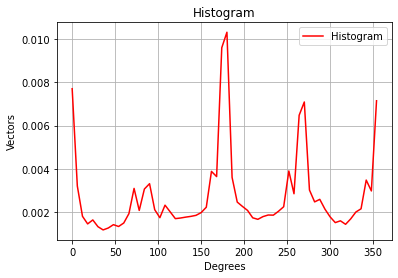

In [226]:
import open3d as o3d
import numpy as np
import copy
import matplotlib.pyplot as plt
import math

pointcloud = o3d.io.read_point_cloud("ReceivedPointcloud.pcd")

points  = np.asarray(pointcloud.points)
normals = np.asarray(pointcloud.normals)

class PointcloudFilter:
    def __init__(self):
        self.points_normals_angles = None
        self.pointcloud = None
        self.points     = None
        self.normals    = None
        self.errorLog = ""
        
    def get_vector_angles(self, vector):
        xy_proj = vector[0:2]
        xy_proj_magn = np.sqrt(xy_proj.dot(xy_proj))
        magnitude = np.sqrt(vector.dot(vector))

        azimuth = np.degrees(np.arccos(vector[0]/xy_proj_magn))
        elevation = np.degrees(np.arcsin(vector[2]/magnitude))

        if vector[1]<0:
            azimuth = 360 - azimuth
        return azimuth, elevation
    
    def extract_spherical_coordinates(self, pointcloud):
        self.points_normals_angles = []
        self.pointcloud = pointcloud
        self.points = np.asarray(self.pointcloud.points)
        self.normals = np.asarray(self.pointcloud.normals)        
        for i in range(len(normals)):
            try:
                azimuth, elevation = self.get_vector_angles(self.normals[i])        
                if math.isnan(azimuth) or math.isnan(elevation):            
                    continue                
                self.points_normals_angles.append([self.points[i], self.normals[i], azimuth, elevation])
            except Exception:
                self.errorLog+=f"{i} WRONG\n"        
        self.points_normals_angles = np.array(self.points_normals_angles)
        
        
    def filter_angles(self, histogram, histogram_edges, threshold):
        angle_filter = histogram > threshold
        filtered_points = []        
        for i in range(len(self.points_normals_angles)):
            for j in range(len(angle_filter)):        
                if angle_filter[j]:            
                    angle = self.points_normals_angles[i,3]
                    if angle >= histogram_edges[j] and angle < histogram_edges[j+1]:
                        filtered_points.append(self.points_normals_angles[i,:])                        
        self.points_normals_angles = np.array(filtered_points)
        
        plt.figure()
        plt.plot(histogram_edges[: -1], histogram, color="red", label = "Histogram")
        #plt.plot(azimuths_bin_edges[:-1], hist_azimuths, color="green", label = "Asimuths histogram")
        #plt.hist(elevations, bins = elevations_bin_edges)
        #plt.hist(azimuths, bins = azimuths_bin_edges)
        plt.xlabel("Degrees")
        plt.ylabel("Vectors")
        plt.grid()
        plt.legend()
        plt.title("Histogram")
        plt.show()        
        
    def filter_points(self, tolerance):        
        azimuths = self.points_normals_angles[:,2]
        elevations = self.points_normals_angles[:,3]
        bins_=int(360/tolerance)
        
        hist_elevations, elevations_bin_edges = np.histogram(elevations, bins = bins_, density = True)
        hist_azimuths,   azimuths_bin_edges   = np.histogram(azimuths,   bins = bins_, density = True)
        
        #self.filter_angles(hist_elevations, elevations_bin_edges, 0.015)       
        self.filter_angles(hist_azimuths, azimuths_bin_edges, 0.001)
        
    def save_filtered_pointcloud(self):
        filtered_pointcloud = o3d.geometry.PointCloud(points = o3d.utility.Vector3dVector(np.empty([0,3])))
        
        filtered_pointcloud.points  = o3d.utility.Vector3dVector(self.points_normals_angles[:,0])
        filtered_pointcloud.normals = o3d.utility.Vector3dVector(self.points_normals_angles[:,1])
        
        o3d.visualization.draw_geometries([filtered_pointcloud], top = 30, left = 0, point_show_normal=True)
        o3d.io.write_point_cloud("FilteredPointcloud.pcd", filtered_pointcloud, False, False, True)

pointcloud_filter = PointcloudFilter()
pointcloud_filter.extract_spherical_coordinates(pointcloud)
pointcloud_filter.filter_points(6)
pointcloud_filter.save_filtered_pointcloud()

